In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.types import Date
from sqlalchemy.sql.expression import and_, extract
from pprint import pprint

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()   
    
#  reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
table_names = inspector.get_table_names()
for table_name in table_names:
    print(table_name)
    columns = inspector.get_columns(table_name)
    pprint(columns)

measurement
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]
station
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'name',
  'nullable': True,
  'primary_key': 0,
  '

# Exploratory Climate Analysis
* Design a query to retrieve the last 12 months of precipitation data and plot the results
* Calculate the date 1 year ago from the last data point in the database
* Perform a query to retrieve the date and precipitation scores
* Save the query results as a Pandas DataFrame and set the index to the date column
* Sort the dataframe by date
* Use Pandas Plotting with Matplotlib to plot the data

In [11]:
# Finding the minimum and maximum dates
min_date, max_date = session.query(func.min(Measurement.date), func.max(Measurement.date)).first()
print(min_date," , ", max_date)

2010-01-01  ,  2017-08-23


In [12]:
# Pulling precipitation data between the dates of 08/23/2016 and 08/23/2017 and saving to a DataFrame
precip_12mnths_q = session.query(Measurement.date, Measurement.prcp).filter(
    and_(Measurement.date >= "2016-08-23", Measurement.date <= "2017-08-23"))

precip_12mnths = precip_12mnths_q.all()
precip_12mnths_df = pd.DataFrame(precip_12mnths).rename(columns={"date": "Date", "prcp": "Precipitation"})
precip_12mnths_df.sort_values(by=["Date"], inplace=True, ascending=False)
precip_12mnths_df.set_index("Date", inplace=True)
precip_12mnths_df

,Precipitation
Date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.00
...,...
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


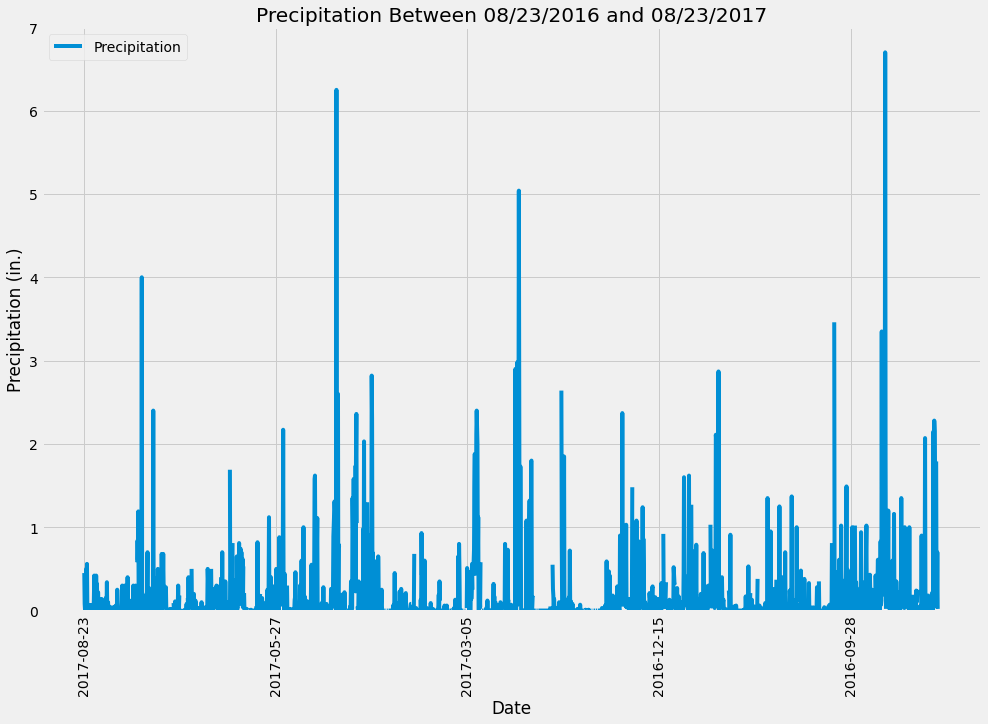

In [13]:
precip_12mnths_df.plot(
    figsize=(15,10),
    ylim=(0,7),
   
    title="Precipitation Between 08/23/2016 and 08/23/2017",
    ylabel="Precipitation (in.)",
    rot=90
)
plt
plt.show()

#### Use Pandas to calcualte the summary statistics for the precipitation data

In [14]:
precip_12mnths_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Design a query to show how many stations are available in this dataset?

In [15]:
station_count = session.query(func.count(Station.id)).all()
print(station_count)

[(9,)]


#### What are the most active stations? (i.e. what stations have the most rows)?
* List the stations and the counts in descending order.

In [16]:
pprint(session.query(Measurement.station, 
func.count(Measurement.id))
.group_by(Measurement.station)
.order_by(func.count(Measurement.station).desc()).all())

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


#### Using the station id from the previous query calculate the following.
* lowest temperature recorded
* highest temperature recorded
* average temperature of 

In [17]:
# Lowest Temperature Recorded
pprint(session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()[0])

54.0


In [18]:
# Highest Temperature Recorded
pprint(session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()[0])

85.0


In [19]:
# Average Temperature
pprint(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()[0])

71.66378066378067


#### Choose the station with the highest number of temperature observations.

In [21]:
pprint(session.query(Measurement.station, 
func.count(Measurement.tobs))
.group_by(Measurement.station)
.order_by(func.count(Measurement.tobs).desc()).all())

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


#### Query the last 12 months of temperature observation data for this station

In [22]:
temp_12mnths_q = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station=="USC00519281").filter(
    and_(Measurement.date >= "2016-08-23", Measurement.date <= "2017-08-23"))
temp_12mnths = temp_12mnths_q.all()
temp_12mnths_df = pd.DataFrame(temp_12mnths).rename(columns={"date": "Date", "tobs": "Temperature"})

temp_12mnths_df.sort_values(by=["Date"], inplace=True, ascending=False)
temp_12mnths_df.set_index("Date", inplace=True)
temp_12mnths_df

,Temperature
Date,
2017-08-18,79.0
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0
...,...
2016-08-27,75.0
2016-08-26,80.0
2016-08-25,80.0


#### Plot the results as a histogram

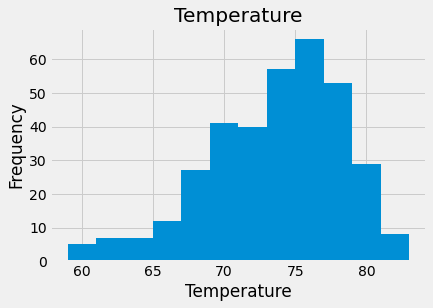

In [23]:
temp_hist = temp_12mnths_df.hist(bins=12)
for ax in temp_hist.flatten():
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


#### Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.


In [25]:
# Using dates 2017 because that is the last year included in this database.
print("[(TMIN, TAVE, TMAX)]")
print(calc_temps('2017-02-13', '2017-02-23'))

[(TMIN, TAVE, TMAX)]
[(65.0, 72.1029411764706, 80.0)]


#### Plot the results from your previous query as a bar chart. 
* Use "Trip Avg Temp" as your Title
* Use the average temperature for the y value
* Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [26]:
# Creating DataFrame
data = [["TMIN", 65.0], ["TAVE", 72.1029411764706], ["TMAX", 80.0]]
df = pd.DataFrame(data, columns = ["Temp Stat Labels", "Temperatures"])
df

,Temp Stat Labels,Temperatures
0,TMIN,65.000000
1,TAVE,72.102941
2,TMAX,80.000000


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
